### **1. Import libraries and dataset**

Import the libraries

In [29]:
import numpy as np ## pip install numpy==2.1 #need this to run ydata-profiling
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency # filter method
from sklearn.preprocessing import MinMaxScaler
#from ydata_profiling import ProfileReport 
import matplotlib.pyplot as plt
from pathlib import Path

import sys


Import the dataset

In [30]:

# Get the current notebook's directory (notebooks folder)
base_path = Path.cwd()

# Get the project root (parent of notebooks folder)
project_root = base_path.parent

# Build the path to the dataset
data_path = project_root / "notebooks"/ "data" / "processed" / "HR_1_1.csv"

# Load the file
HR_1_1 = pd.read_csv(data_path)

print(f"Loaded HR_1_1 from: {data_path}")
print(f"Dataset shape: {HR_1_1.shape}")


Loaded HR_1_1 from: c:\Projects\EDSB25_10\EDSB25_10\notebooks\data\processed\HR_1_1.csv
Dataset shape: (1470, 52)


## **2. Feature Selection**

The purpose of this section is to analyze potential correlations among the various variables in the dataset as a form of filter **Feature Selection**.

**Numerical features** were scaled using `MinMaxScaler()`. **Categorical features** were **encoded** and converted into numerical representations so that machine learning algorithms can process and interpret them effectively.

### **2.1. Spearman correlation analysis**

Spearman is useful to understand if there are redundant features with high correlation to disconsider. It is suitable for continuous and ordinal data.

In [31]:
correlation_HR_1_1 = HR_1_1.corr(method='spearman', numeric_only=True)
correlation_HR_1_1

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
Age,1.000000,-0.171214,0.007290,-0.019291,0.204937,0.009820,0.028858,0.034456,0.489618,-0.005185,...,0.184877,-0.152827,-0.001102,-0.174193,-0.021040,0.018513,-0.036088,0.077494,-0.113026,0.027044
Attrition,-0.171214,1.000000,-0.056970,0.079248,-0.030346,-0.096486,-0.006692,-0.119496,-0.190370,-0.102948,...,-0.088870,-0.000360,0.019774,0.157234,0.115143,-0.049538,0.029453,-0.090984,0.175419,0.246118
DailyRate,0.007290,-0.056970,1.000000,-0.002754,-0.013607,0.018961,0.023511,0.042469,0.003816,0.027829,...,0.000897,-0.002829,-0.000181,0.005845,-0.012103,0.002207,-0.011415,0.040180,-0.076012,0.008383
DistanceFromHome,-0.019291,0.079248,-0.002754,1.000000,0.015708,-0.010401,0.020446,0.034430,0.022148,-0.013078,...,-0.018166,-0.016738,0.044678,-0.005625,-0.008361,-0.004095,0.004387,0.017019,-0.026259,0.036639
Education,0.204937,-0.030346,-0.013607,0.015708,1.000000,-0.027625,0.014432,0.037231,0.107419,-0.005175,...,0.046079,0.004425,0.051082,-0.083289,-0.006252,0.002990,-0.009903,-0.001209,0.006131,-0.017003
EnvironmentSatisfaction,0.009820,-0.096486,0.018961,-0.010401,-0.027625,1.000000,-0.052380,-0.015301,-0.000192,-0.002993,...,-0.046003,0.003960,-0.024693,-0.001975,-0.010527,0.007131,0.001863,-0.028464,0.013736,0.067670
HourlyRate,0.028858,-0.006692,0.023511,0.020446,0.014432,-0.052380,1.000000,0.043884,-0.033876,-0.068340,...,-0.025475,0.019262,-0.012116,-0.018345,-0.019292,0.028003,-0.000278,0.035371,-0.032502,-0.009140
JobInvolvement,0.034456,-0.119496,0.042469,0.034430,0.037231,-0.015301,0.043884,1.000000,-0.018424,-0.012148,...,0.016192,0.044358,-0.010484,-0.022248,0.006497,0.019436,0.022468,0.022918,-0.046740,-0.001866
JobLevel,0.489618,-0.190370,0.003816,0.022148,0.107419,-0.000192,-0.033876,-0.018424,1.000000,-0.000852,...,0.348861,-0.439853,0.251200,-0.254342,-0.016058,0.008832,-0.050875,0.050213,-0.090430,-0.000394
JobSatisfaction,-0.005185,-0.102948,0.027829,-0.013078,-0.005175,-0.002993,-0.068340,-0.012148,-0.000852,1.000000,...,-0.008418,0.020304,0.017436,-0.002888,0.027756,-0.034014,0.035627,-0.013665,0.026268,0.028522


In [32]:
sorted_columns = sorted(correlation_HR_1_1.columns)
correlation_HR_1_1_sorted = correlation_HR_1_1.loc[sorted_columns, sorted_columns]

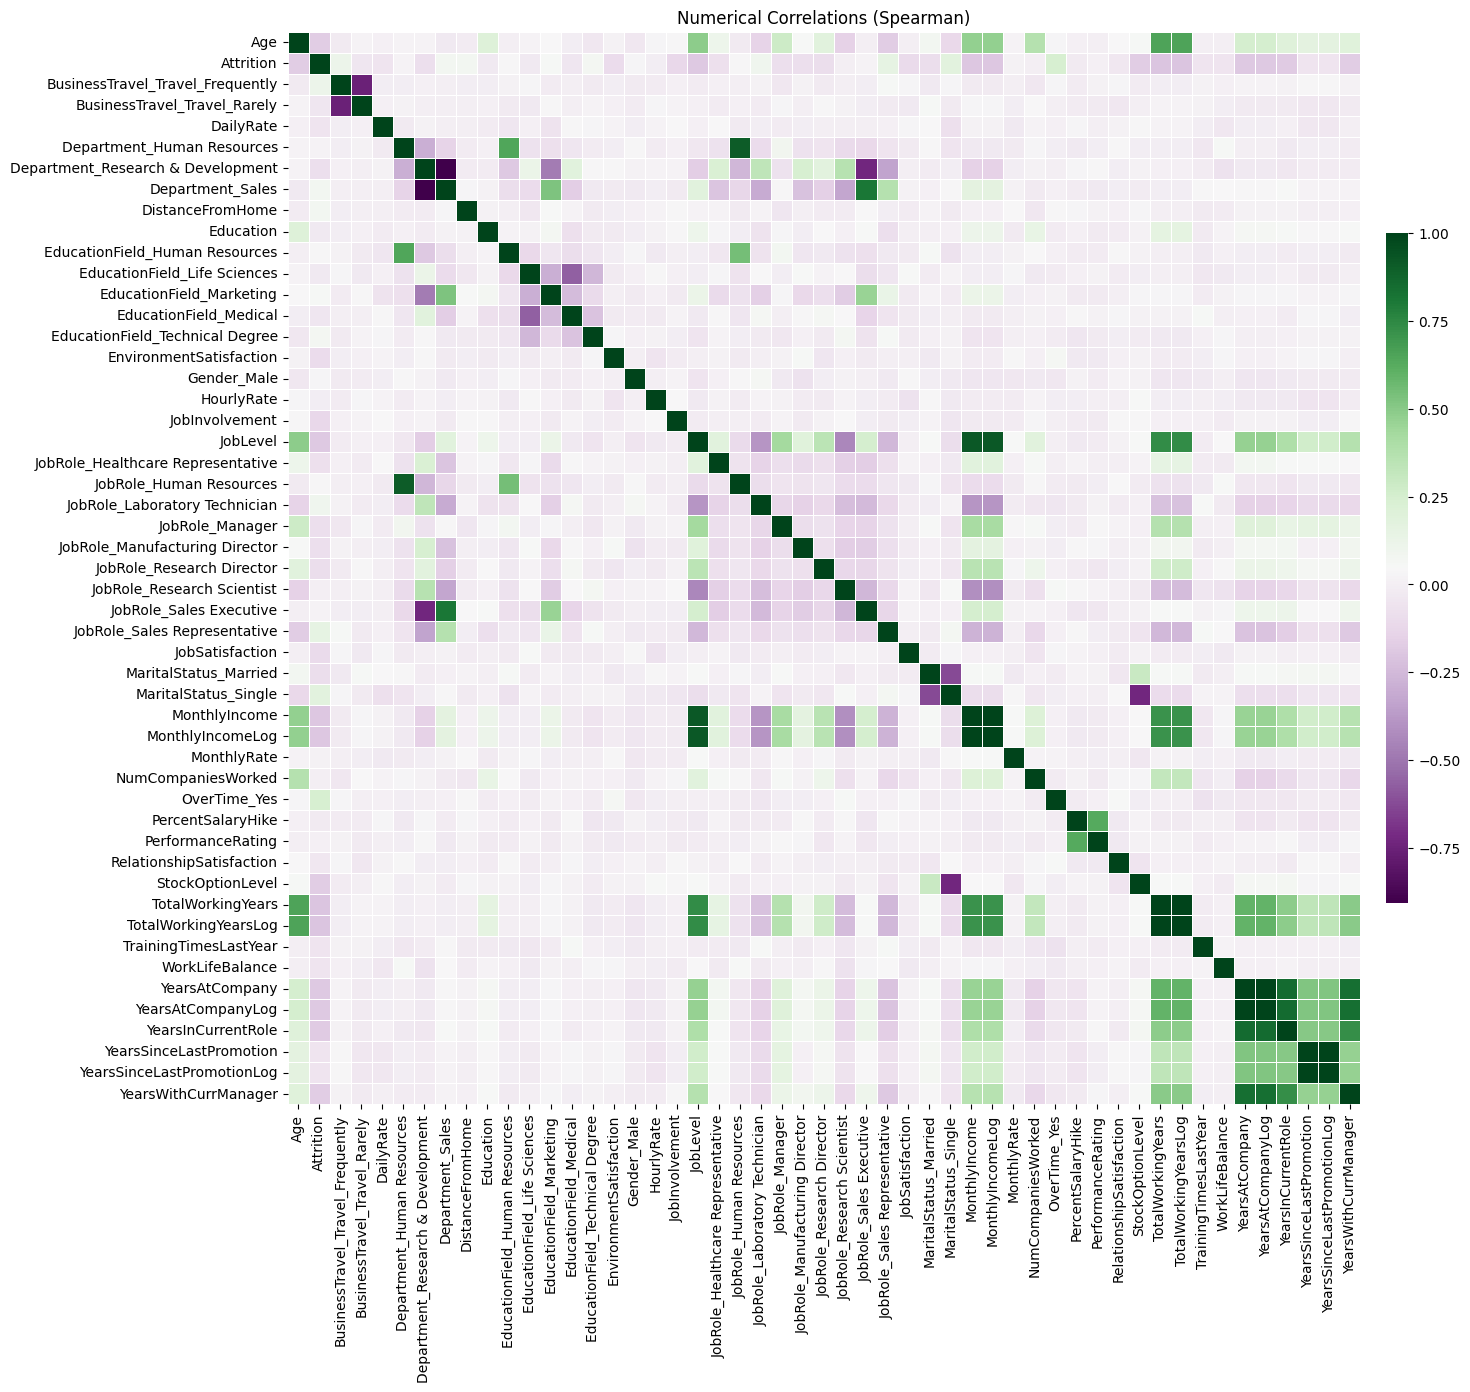

In [33]:
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_HR_1_1_sorted, cmap="PRGn", square=True, linewidths=0.5, annot=False, cbar_kws={
        'shrink': 0.6,      # Makes colorbar smaller (60% of default)
        'aspect': 30,        # Makes colorbar narrower
        'pad': 0.02          # Adds space between plot and colorbar
    })
plt.title("Numerical Correlations (Spearman)")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

#### **Insights**
**Highlights of features and target category:**

The image above allows to conclude that aren't strong correlations between the features and the target variable (Attrition). However, some points to hightlight 

- **Attrition and Age:** the spearman correlation coefficient is -0.171214, which is a negative relationship. This can be interpreted as the age increases the attrition score decreases, so <u>older employees are less likely to leave the company</u>. However, the score is low so the variable by itself doesn't explain the attrition. 

- **Attrition and Job Level:** the spearman correlation coefficient is -0.190370, also a negative relationship. The job level variable represents the hierarchy at the company and this suggests that <u> as the level is higher, the attrition score decreases</u>.

- **Attrition and Monthly Income:** the spearman correlation coefficient is -0.199086, also a negative relationship. As the monthly income increases the attrition score tends to be lower, indicating that <u>higher incomes are associated with a lower rate of employee turnover</u>.

- **Attrition and Total Working Years:** the spearman correlation coefficient is -0.199320, which indicates that <u>more years working represents a decrease in the attrition score</u>. It corroborates the age seen previously, although it is interesting that the age itself doesn't have a strong correlation with the total working years.

- **Attrition and Years at the Company:** the spearman correlation coefficient is -0.191121, which indicates a <u>lower score of attrition when the employee has more years of work in the company</u>.

- **Attrition and Years in the Current Role:** the spearman correlation coefficient is -0.180566, indicates that <u>more years in the current rule are slightly related with lower attrition score</u>.

- **Attrition and Years with the Current Manager:** the spearman correlation coefficient is -0.175355, indicates that <u>more years with the current manager represents a lower attrition score</u>.

**Highlights of other feature relations:**

The strongest correlation coefficients -  the darkest spots were observed among the dummy variables for features like Department, Gender, and Marital Status due to the structural artifacts of the data encoding process, not signals of real-world predictive power. 

These strong relationships, particularly the high negative ones, result from multicollinearity. When a categorical feature with $N$ options is converted into $N$ binary dummy columns (e.g., Gender_Male and Gender_Female), the columns are perfectly or near-perfectly dependent: if one is 1' (True), the other(s) must be '0' (False). 

For instance, the perfect negative correlation of $-1.0$ between Gender_Male and Gender_Female simply confirms that a person cannot be both simultaneously. 

While mathematically sound, these high correlations are uninformative for predicting Attrition and would be ignored when assessing external factors influencing employee turnover.

The focus must remain on the weaker, yet meaningful, correlations found between the demographic/satisfaction variables and the target variable, Attrition.

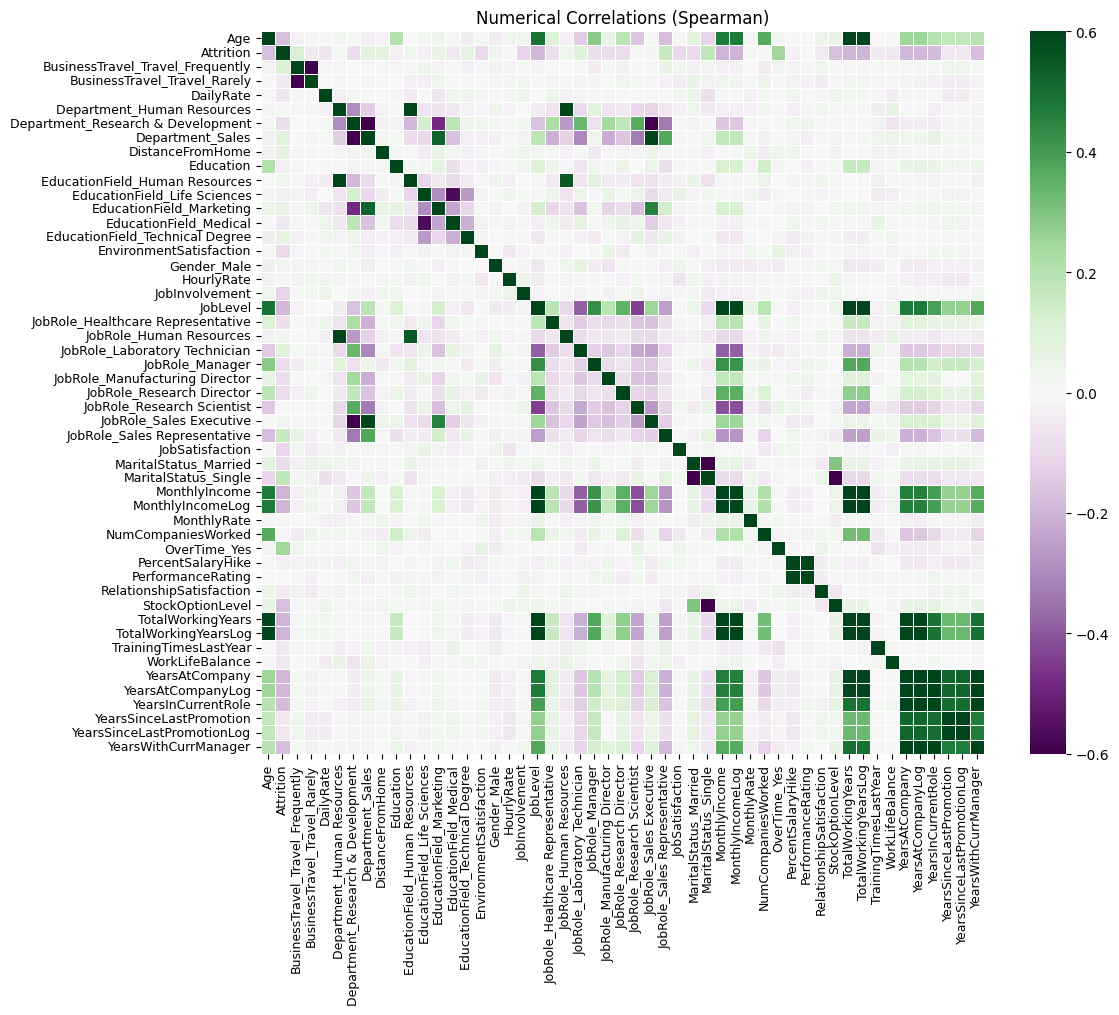

In [34]:
correlation1 = HR_1_1.corr(method='spearman', numeric_only=True)

sorted_columns = sorted(correlation1.columns)
correlation1_sorted = correlation1.loc[sorted_columns, sorted_columns]

numeric_cols = HR_1_1.select_dtypes(include=['number']).columns

#scaler = MinMaxScaler()
#correlation1[numeric_cols] = scaler.fit_transform(correlation1[numeric_cols])

plt.figure(figsize=(12, 10))
sns.heatmap(correlation1_sorted, cmap="PRGn", square=True, linewidths=0.5, vmin=-0.6, vmax=0.6, annot=False)
plt.title("Numerical Correlations (Spearman)")
plt.xticks(rotation=90, fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

### **2.2. Remove redundant variables (>0.65 correlation)**

Use the variables studied on the Spearman correlation analysis

In [35]:
correlation1_sorted

,Age,Attrition,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,DailyRate,Department_Human Resources,Department_Research & Development,Department_Sales,DistanceFromHome,Education,...,TotalWorkingYears,TotalWorkingYearsLog,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsAtCompanyLog,YearsInCurrentRole,YearsSinceLastPromotion,YearsSinceLastPromotionLog,YearsWithCurrManager
Age,1.000000,-0.171214,-0.021040,0.018513,0.007290,0.020814,0.018278,-0.028086,-0.019291,0.204937,...,0.656802,0.656802,0.001396,-0.003707,0.250337,0.250337,0.197952,0.171492,0.171492,0.194821
Attrition,-0.171214,1.000000,0.115143,-0.049538,-0.056970,0.016832,-0.085293,0.080855,0.079248,-0.030346,...,-0.199320,-0.199320,-0.051347,-0.051951,-0.191121,-0.191121,-0.180566,-0.053762,-0.053762,-0.175355
BusinessTravel_Travel_Frequently,-0.021040,0.115143,1.000000,-0.753092,-0.012103,-0.007485,0.003340,-0.000160,-0.008361,-0.006252,...,-0.011014,-0.011014,0.011582,0.007543,0.017300,0.017300,0.016146,0.035392,0.035392,0.012914
BusinessTravel_Travel_Rarely,0.018513,-0.049538,-0.753092,1.000000,0.002207,0.009618,0.000465,-0.004718,-0.004095,0.002990,...,0.023961,0.023961,0.010540,-0.009466,-0.022730,-0.022730,-0.024599,-0.037283,-0.037283,-0.023301
DailyRate,0.007290,-0.056970,-0.012103,0.002207,1.000000,-0.027101,0.014350,-0.002912,-0.002754,-0.013607,...,0.021733,0.021733,-0.012206,-0.040352,-0.009335,-0.009335,0.007281,-0.037863,-0.037863,-0.004716
Department_Human Resources,0.020814,0.016832,-0.007485,0.009618,-0.027101,1.000000,-0.290754,-0.139650,-0.017161,0.006396,...,-0.006498,-0.006498,-0.036966,0.055457,-0.000763,-0.000763,-0.029643,-0.007159,-0.007159,-0.014794
Department_Research & Development,0.018278,-0.085293,0.003340,0.000465,0.014350,-0.290754,1.000000,-0.906818,-0.019487,-0.017674,...,0.009327,0.009327,-0.019138,-0.067055,-0.035285,-0.035285,-0.037378,-0.015640,-0.015640,-0.014655
Department_Sales,-0.028086,0.080855,-0.000160,-0.004718,-0.002912,-0.139650,-0.906818,1.000000,0.027727,0.015473,...,-0.006790,-0.006790,0.036092,0.044964,0.036853,0.036853,0.051742,0.019340,0.019340,0.021685
DistanceFromHome,-0.019291,0.079248,-0.008361,-0.004095,-0.002754,-0.017161,-0.019487,0.027727,1.000000,0.015708,...,-0.003065,-0.003065,-0.025876,-0.020402,0.011119,0.011119,0.013732,-0.005071,-0.005071,0.004422
Education,0.204937,-0.030346,-0.006252,0.002990,-0.013607,0.006396,-0.017674,0.015473,0.015708,1.000000,...,0.161789,0.161789,-0.022948,0.017350,0.063552,0.063552,0.054589,0.032035,0.032035,0.051270


- Age (-0.17) is highly overall correlated with **TotalWorkingYears** (-0.20)
- Department (0.08) is highly overall correlated with EducationField (0.07) and JobRole (0.16)
- EducationField (0.07) is highly overall correlated with Department (0.08)
- JobLevel (-0.19) is highly overall correlated with JobRole (0.16),  MonthlyIncome (0.015), and **TotalWorkingYears (-0.20)**
- JobRole (0.16) is highly overall correlated with Department (0.08) and JobLevel (-0.19)
- **MaritalStatus (0.18)** is highly overall correlated with StockOptionLevel (-0.17)
- MonthlyIncome (0.015) is highly overall correlated with JobLevel (-0.19) and **TotalWorkingYears** (-0.20)
- **PercentSalaryHike (-0.02)** is highly overall correlated with PerformanceRating (---)
- PerformanceRating (---) is highly overall correlated with PercentSalaryHike (-0.02)
- StockOptionLevel (-0.17) is highly overall correlated with **MaritalStatus** (0.18)
- **TotalWorkingYears (-0.20)** is highly overall correlated with Age (-0.17), JobLevel (-0.19), YearsAtCompany (-0.19) and MonthlyIncome (0.015)
- YearsAtCompany (-0.19) is highly overall correlated with **TotalWorkingYears (-0.20)**, YearsInCurrentRole (-0.18), YearsSinceLastPromotion (-0.05), YearsWithCurrManager (-0.18) 
- YearsInCurrentRole (-0.18) is highly overall correlated with **YearsAtCompany (-0.19)**, YearsSinceLastPromotion (-0.05), YearsWithCurrManager (-0.18)
- YearsSinceLastPromotion (-0.05) is highly overall correlated with YearsAtCompany (-0.19) and YearsInCurrentRole (-0.18)
- YearsWithCurrManager (-0.18) is highly overall correlated with YearsAtCompany (-0.19) and YearsInCurrentRole (-0.18)

**If two variables are correlated, we drop one of them, keeping the variable with largest correlation with the target**

Remove:
- Age
- Department
- EducationField
- JobLevel
- JobRole
- StockOptionLevel
- MonthlyIncome
- PerformanceRating
- YearsInCurrentRole

Keep:
- TotalWorkingYears
- MaritalStatus
- PercentSalaryHike
- YearsAtCompany

In [37]:
HR_1_1.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,1102,1,2,2,94,3,2,4,...,False,False,True,False,False,True,False,False,True,True
1,49,0,279,8,1,3,61,2,2,2,...,False,True,False,False,True,False,True,True,False,False
2,37,1,1373,2,2,4,92,2,1,3,...,False,False,False,False,False,True,True,False,True,True
3,33,0,1392,3,4,4,56,3,1,3,...,False,True,False,False,True,False,False,True,False,True
4,27,0,591,2,1,1,40,3,1,2,...,False,False,False,False,False,True,True,True,False,False


In [38]:
# If two variables are correlated, we drop one of them, keeping the variable with largest correlation with the target

# Compute correlation matrix
corr_matrix = HR_1_1.corr().abs()


# Target variable correlation
target = 'Attrition'
target_corr = corr_matrix[target].drop(target)  # drop self-correlation

# Correlation threshold
threshold = 0.65

# Initialize set for dropped columns
drop_cols = set()

# Iterate over the upper triangle of the correlation matrix
for i in range(len(corr_matrix.columns)):
    col1 = corr_matrix.columns[i]
    if col1 == target or col1 in drop_cols:
        continue

    for j in range(i + 1, len(corr_matrix.columns)):
        col2 = corr_matrix.columns[j]
        if col2 == target or col2 in drop_cols:
            continue

        # Check correlation between two features
        if corr_matrix.iloc[i, j] > threshold:
            # Compare correlation with target
            corr1 = target_corr.get(col1, 0)
            corr2 = target_corr.get(col2, 0)

            # Drop the one with smaller correlation to target
            if corr1 >= corr2:
                drop_cols.add(col2)
            else:
                drop_cols.add(col1)

print("Columns to drop due to high correlation:", drop_cols)
print("Number of columns to drop:", len(drop_cols))

# Create final dataset
HR_final = HR_1_1.drop(columns=list(drop_cols))
print("Final dataset shape:", HR_final.shape)
HR_final.head()


ValueError: could not convert string to float: '36-45'

In [39]:
print("Kept columns:", [c for c in HR_final.columns if c not in drop_cols])


Kept columns: ['Attrition', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobSatisfaction', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance', 'TotalWorkingYearsLog', 'YearsAtCompanyLog', 'YearsSinceLastPromotionLog', 'AgeGroup', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales', 'EducationField_Human Resources', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Technical Degree', 'JobRole_Healthcare Representative', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', 'JobRole_Research Scientist', 'JobRole_Sales Executive', 'JobRole_Sales Representative', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Gender_Male', 'MaritalStatus_Mar

#### Insights
From the redundant variables (>0.65 Spearman Correlation) we decided to:

Remove:
- Age
- Department
- EducationField
- JobLevel
- JobRole
- StockOptionLevel
- MonthlyIncome
- PerformanceRating
- YearsInCurrentRole

Keep:
- TotalWorkingYears
- MaritalStatus
- PercentSalaryHike
- YearsAtCompany

Non-redundant variables to keep in the dataset:
- EmployeeNumber
- Attrition
- DailyRate
- DistanceFromHome
- Education
- EnvironmentSatisfaction
- HourlyRate
- JobInvolvement
- JobSatisfaction
- NumCompaniesWorked
- PercentSalaryHike
- PerformanceRating
- RelationshipSatisfaction
- TrainingTimesLastYear
- WorkLifeBalance
- TotalWorkingYearsLog
- YearsAtCompanyLog
- YearsSinceLastPromotionLog
- Department_Research & Development
- EducationField_Human Resources
- EducationField_Life Sciences
- EducationField_Marketing
- EducationField_Medical
- EducationField_Technical Degree
- JobRole_Healthcare Representative
- JobRole_Human Resources
- JobRole_Laboratory Technician
- JobRole_Manager
- JobRole_Manufacturing Director
- JobRole_Research Director
- JobRole_Research Scientist
- JobRole_Sales Representative
- BusinessTravel_Travel_Frequently
- Gender_Male
- MaritalStatus_Married
- MaritalStatus_Single
- OverTime_Yes

### **2.3. Applying StratifiedKFold with chi-squared contingency**

We can use StratifiedKFold to better grasp the variables required to predict the Attrition target.

In [ ]:
from sklearn.model_selection import StratifiedKFold

def select_best_cat_features(X, y, columns, n_splits=5, alpha=0.05):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    categorical_cols = columns

    significance_counts = {col: 0 for col in categorical_cols}

    for count, (train_index, val_index) in enumerate(skf.split(X, y), start=1):
        print(f'\n{"_"*40}\nSPLIT {count}\n')

        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_cat = X_train[categorical_cols]

        for col in X_cat.columns:
            contingency = pd.crosstab(X_cat[col], y_train)

            # --- NEW: skip empty tables ---
            if contingency.size == 0:
                print(f"{col}: skipped (empty contingency table)")
                continue

            # --- NEW: require at least TWO categories and TWO classes ---
            if contingency.shape[0] < 2 or contingency.shape[1] < 2:
                print(f"{col}: skipped (not enough categories/classes)")
                continue

            _, p, _, _ = chi2_contingency(contingency)
            if p < alpha:
                print(f"{col}: SIGNIFICANT (p={p:.4f})")
                significance_counts[col] += 1
            else:
                print(f"{col}: NOT significant (p={p:.4f})")

    print("\nSummary of significance across splits:")
    summary = pd.DataFrame.from_dict(significance_counts, orient='index', columns=['Significant_Splits'])
    summary['% Splits Significant'] = (summary['Significant_Splits'] / n_splits) * 100
    return summary.sort_values(by='Significant_Splits', ascending=False)

In [ ]:
# check which variables significantly associate with the Attrition target variable
y = HR_final['Attrition'].copy()
X = HR_final.drop(columns=['Attrition']).copy()

# Select categorical and binary-like columns
columns = X.columns.tolist()

# Run Chi-Squared feature selection
result_df = select_best_cat_features(X, y, columns=columns)
print(result_df)

In [ ]:
best_predictors = result_df[result_df['% Splits Significant'] >= 80].index.tolist()
print("Best predictors (significant in at least 80% of splits):", best_predictors)

In [ ]:
valid_best_predictors = [col for col in best_predictors if col in HR_final.columns]

missing = [col for col in best_predictors if col not in HR_final.columns]

print("Missing columns:", missing)
print("Using predictors:", valid_best_predictors)


In [ ]:
# Create best dataframe
HR_best = HR_final[best_predictors + ['Attrition']].copy()
#sorted_best_columns = sorted(HR_best.columns)
#HR_best_sorted = HR_best.loc[sorted_best_columns, sorted_best_columns]
HR_best = HR_best.reindex(sorted(HR_best.columns), axis=1)
HR_best

#### Insights
The variables: 
- BusinessTravel
- Department
- EnvironmentSatisfaction
- JobInvolvement
- JobRole
- JobSatisfaction 
- MaritalStatus
- NumCompaniesWorked
- OverTime  
- TotalWorkingYears
- WorkLifeBalance
- YearsAtCompany

all seem relevant to predict if a person will leave the company or not.

In [ ]:
# Spearman correlation of the best dataset for predicting Attrition
correlation_HR_best = HR_best.corr(method='spearman', numeric_only=True)
correlation_HR_best

In [ ]:
sorted_columns = sorted(correlation_HR_best.columns)
correlation_HR_best_sorted = correlation_HR_best.loc[sorted_columns, sorted_columns]

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_HR_best_sorted, cmap="PRGn", square=True, vmin=-0.6, vmax=0.6, linewidths=0.5, annot=False, cbar_kws={
        'shrink': 0.6,      # Makes colorbar smaller (60% of default)
        'aspect': 30,        # Makes colorbar narrower
        'pad': 0.02          # Adds space between plot and colorbar
    })
plt.title("Numerical Correlations (Spearman)")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

Now there are no more correlations > 0.65 (the cut-off utilised before).

Single and Married should both stay because, although they are mildly correlated, they are both involved in predicting the target and there is a Divorced class that can be inferred from the values of both columns.

In [ ]:
HR_best

## **3. Feature Engineering**

### **3.1. Create new variables based on domain knowledge**

In [ ]:
# Analyse if big differences between monthly rates and montly income may influence the target variable.
HR_best['rate_income'] = HR_1_1['MonthlyRate'] - HR_1_1['MonthlyIncome']
#HR_best['Income_per_YearAtCompany'] = HR_best['MonthlyIncomeLog'] / (HR_best['YearsAtCompanyLog'] + 1) # unfortunately MonthlyIncomeLog was dropped
HR_best['WorkLifeBalance_OverTime'] = HR_best['WorkLifeBalance'] - HR_best['OverTime_Yes'] # -> -0.23 correlation
HR_best['Job_happiness_score'] = HR_best['JobInvolvement'] + HR_best['JobSatisfaction'] + HR_best['YearsAtCompanyLog'] + HR_best['EnvironmentSatisfaction'] + HR_best['WorkLifeBalance'] - HR_best['OverTime_Yes'] #-> -0.33 correlation
# HR_best['Job_happiness_score_test'] = (HR_best['JobInvolvement'] * HR_best['JobSatisfaction'] * HR_best['YearsAtCompanyLog'] * HR_best['EnvironmentSatisfaction'] * HR_best['WorkLifeBalance']) / (HR_best['OverTime_Yes']+1) -> -0.20 correlation

# 1. Tenure-to-Experience Ratio (loyalty indicator)
HR_best['TenureExperienceRatio'] = HR_best['YearsAtCompanyLog'] / (HR_best['TotalWorkingYearsLog'] + 1e-5)
        
# 2. Income per Year of Experience (earning efficiency)
HR_best['IncomePerExperience'] = HR_1_1['MonthlyIncomeLog'] / (HR_best['TotalWorkingYearsLog'] + 1e-5)
        
# 3. Promotion Recency Score (career momentum)
HR_best['PromotionRecency'] = HR_best['YearsAtCompanyLog'] - HR_1_1['YearsSinceLastPromotionLog']

HR_best.head()

In [ ]:
from scipy.stats import pointbiserialr

# Calculate point biserial correlation
variables = ['rate_income', 'WorkLifeBalance_OverTime', 'Job_happiness_score', 'TenureExperienceRatio', 'IncomePerExperience', 'PromotionRecency']
for variable in variables:
    correlation, p_value = pointbiserialr(HR_best[variable], HR_best['Attrition'])

    print(f"Point Biserial Correlation for {variable}: {correlation:.4f}")
    print(f"P-value for {variable}: {p_value:.4e}")

Job happiness score seems very significantly correlated with Attrition.

In [ ]:
correlation_HR_best = HR_best.corr(method='spearman', numeric_only=True)
correlation_HR_best

### **3.2. Testing whether new variables introduce redundant information**

We should now test whether the new feature engineering variables generate new redundant information with the previous dataset.

In [ ]:
# This cell was meant to test whether the new feature engineering variables are redundant with the rest

# If two variables are correlated, we drop one of them, keeping the variable with largest correlation with the target

# Compute correlation matrix
corr_matrix = HR_best.corr().abs()

# Target variable correlation
target = 'Attrition'
target_corr = corr_matrix[target].drop(target)  # drop self-correlation

# Correlation threshold
threshold = 0.65

# Initialize set for dropped columns
drop_cols = set()

# Iterate over the upper triangle of the correlation matrix
for i in range(len(corr_matrix.columns)):
    col1 = corr_matrix.columns[i]
    if col1 == target or col1 in drop_cols:
        continue

    for j in range(i + 1, len(corr_matrix.columns)):
        col2 = corr_matrix.columns[j]
        if col2 == target or col2 in drop_cols:
            continue

        # Check correlation between two features
        if corr_matrix.iloc[i, j] > threshold:
            # Compare correlation with target
            corr1 = target_corr.get(col1, 0)
            corr2 = target_corr.get(col2, 0)

            # Drop the one with smaller correlation to target
            if corr1 >= corr2:
                drop_cols.add(col2)
            else:
                drop_cols.add(col1)

print("Columns to drop due to high correlation:", drop_cols)
print("Number of columns to drop:", len(drop_cols))

# Create final dataset
#HR_best_final = HR_best.drop(columns=list(drop_cols))
#print("Final dataset shape:", HR_best_final.shape)
#HR_best_final.head()


The previous cell suggested we remove WorkLifeBalance, as it was significantly correlated (>0.65) with WorkLifeBalance_OverTime.

However, we will make the decision of keeping WorkLifeBalance instead of the new feature engineered variable.

We will keep Job_happiness_score as it was not considered redundant with its original variables.

In [ ]:
# drop WorkLifeBalance_OverTime
HR_best.drop('WorkLifeBalance_OverTime', axis=1, inplace=True)
HR_best

### **3.3. Final correlation plot of the best and engineered variables**

In [ ]:
corr_final = HR_best.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_final, cmap="PRGn", square=True, linewidths=0.5, vmin=-0.6, vmax=0.6, annot=False, cbar_kws={
        'shrink': 0.6,      # Makes colorbar smaller (60% of default)
        'aspect': 30,        # Makes colorbar narrower
        'pad': 0.02          # Adds space between plot and colorbar
    })
plt.title("Numerical Correlations (Spearman)")
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

The plot above shows that all the features that remain in the dataset are somehow correlated with Attrition.

## **4. Saving the best DataFrame and Final Insights**

In [ ]:
# Save the processed dataset
HR_best.to_csv('data/processed/HR_best_features.csv', index=True)

The variables: 
- BusinessTravel
- Department
- EnvironmentSatisfaction
- JobInvolvement
- JobRole
- JobSatisfaction 
- MaritalStatus
- NumCompaniesWorked
- OverTime  
- TotalWorkingYears
- WorkLifeBalance
- YearsAtCompany

all seem relevant to predict if a person will leave the company or not.